# 🧪 SEE Evaluator
This notebook evaluates VLM-generated screen descriptions using GPT-4o and DeepEval. It measures both Reference Coverage and Must-Include Coverage against the SEE-Benchmark annotations.

# 📦 Step 1: Setup and Imports

In [7]:
import os
import base64
import json
import pandas as pd
from pathlib import Path
from datetime import datetime
from dotenv import load_dotenv
from together import Together
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

load_dotenv()

True

In [10]:
with open("../annotation_dataset/annotations.json", "r", encoding="utf-8") as f:
    annotations = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '../annotation_dataset/annotations.json'

In [14]:
# Part 1: Complete metrics definition
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams
from deepeval.evaluate import AsyncConfig

# Your existing reference coverage metric
reference_coverage_eval = GEval(
    name="Referentie-dekking (SEE-Benchmark)",
    criteria=(
        "Beoordeel hoe goed de modeloutput overeenkomt met de essentie van de referentiebeschrijving. "
        "Vergelijk het met het nakijken van een open vraag: parafraseren en andere woordvolgorde mogen, zolang de kern van het antwoord gelijk blijft. "
        "Hoe meer belangrijke en relevante elementen correct aanwezig zijn, hoe hoger de score. "
        "De beschrijving moet functioneel bruikbaar zijn voor een blinde gebruiker en volledig in het Nederlands zijn."
    ),
    evaluation_params=[
        LLMTestCaseParams.ACTUAL_OUTPUT,
        LLMTestCaseParams.EXPECTED_OUTPUT
    ],
    evaluation_steps=[
        "De beschrijving moet volledig in het Nederlands zijn. Engelse termen zijn alleen toegestaan als ze letterlijk ook in de referentie staan. Als er Engelse termen voorkomen die niet in de referentie staan, geef een lage score (onder 0.3).",
        "Controleer of alle belangrijke en functioneel relevante elementen uit de referentie aanwezig zijn in de modeloutput, ook als ze net anders genoemd worden, zolang de essentie van het functioneel relevante element maar overkomt. Als er iets ontbreekt, trek dan punten af.",
        "Parafrasering is toegestaan, zolang betekenis en inhoud behouden blijven. Als de betekenis verandert of vager wordt, trek dan punten af.",
        "Als er elementen genoemd worden die niet in de referentie staan (zoals extra knoppen of functionaliteiten), trek dan punten af.",
        "Als de modeloutput visuele of stilistische details bevat die niet in de referentie staan én geen functioneel doel dienen, trek dan punten af.",
        "Als de modeloutput veel langer is dan nodig of onnodige omschrijvingen bevat, trek dan punten af."
    ],
    model="gpt-4o",
    threshold=0.7
)

# New metric for must-include elements
must_include_coverage_eval = GEval(
    name="Verplichte Elementen Dekking",
    criteria="Alle verplichte elementen uit de lijst moeten herkenbaar en in het Nederlands aanwezig zijn in de modeloutput, ook als synoniem of parafrase. Het belangrijkste is dat de essentie van het element behouden blijft.",
    evaluation_params=[
        LLMTestCaseParams.ACTUAL_OUTPUT,
        LLMTestCaseParams.INPUT
    ],
    evaluation_steps=[
        "Controleer voor elk verplicht element of het in de output staat, ook synoniemen of parafraseringen tellen even zwaar mee."
        "Als alles aanwezig is telt dit sterk mee."
    ],
    model="gpt-4o",
    threshold=0.8
)

In [15]:
# Part 2: Complete evaluation script
from deepeval import evaluate
from deepeval.test_case import LLMTestCase
import pandas as pd

# Load your model outputs
model_outputs_df = pd.read_excel("../script/results/meta-llama/Llama-4-Scout-17B-16E-Instruct_two-shot_20250628_0649.xlsx")

# Create test cases for both metrics
reference_test_cases = []
must_include_test_cases = []

for idx, row in model_outputs_df.iterrows():
    image_id = str(row['image_id']).zfill(3)
    model_output = row['model_output']

    # Find reference description
    reference = None
    must_include_elements = []
    
    for annotation in annotations:
        ann_id = str(annotation.get('image_id', '')).strip()
        if ann_id == image_id:
            reference = annotation.get('reference_description', None)
            must_include_elements = annotation.get('must_include', [])
            break

    if reference is None:
        print(f"Warning: No reference found for image_id {image_id}")
        continue

    # Test case for reference coverage
    reference_test_cases.append(
        LLMTestCase(
            input="",
            actual_output=model_output,
            expected_output=reference,
            additional_metadata={"image_id": image_id, "metric": "reference_coverage"}
        )
    )

    # Test case for must-include coverage (only if must_include elements exist)
    if must_include_elements:
        # Format the must_include elements for the input
        must_include_input = f"Verplichte elementen die aanwezig moeten zijn: {must_include_elements}"
        
        must_include_test_cases.append(
            LLMTestCase(
                input=must_include_input,
                actual_output=model_output,
                expected_output="",  # Not used for this metric
                additional_metadata={"image_id": image_id, "metric": "must_include_coverage", "must_include": must_include_elements}
            )
        )

print(f"Created {len(reference_test_cases)} reference coverage test cases")
print(f"Created {len(must_include_test_cases)} must-include coverage test cases")

print("Running reference coverage evaluation...")
reference_results = evaluate(test_cases=reference_test_cases, metrics=[reference_coverage_eval])

print("Running must-include coverage evaluation...")
must_include_results = evaluate(test_cases=must_include_test_cases, metrics=[must_include_coverage_eval])


Created 100 reference coverage test cases
Created 100 must-include coverage test cases
Running reference coverage evaluation...


✨ You're running DeepEval's latest Referentie-dekking (SEE-Benchmark) (GEval) Metric! (using gpt-4o, strict=False,
async_mode=True)...

Evaluating 100 test case(s) in parallel: |          |  1% (1/100) [Time Taken: 00:05,  5.55s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |▍         |  4% (4/100) [Time Taken: 00:06,  1.08s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |▌         |  6% (6/100) [Time Taken: 00:06,  1.63test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█▋        | 17% (17/100) [Time Taken: 00:08,  5.99test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█▊        | 18% (18/100) [Time Taken: 00:09,  2.08test case/s]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██        | 21% (21/100) [Time Taken: 00:13,  1.13test case/s]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██▏       | 22% (22/100) [Time Taken: 00:13,  1.35test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██▎       | 23% (23/100) [Time Taken: 00:13,  1.58test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██▌       | 25% (25/100) [Time Taken: 00:14,  2.22test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██▉       | 29% (29/100) [Time Taken: 00:15,  4.38test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███▊      | 38% (38/100) [Time Taken: 00:16,  8.09test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████      | 41% (41/100) [Time Taken: 00:21,  1.16s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████▏     | 42% (42/100) [Time Taken: 00:21,  1.12test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████▎     | 43% (43/100) [Time Taken: 00:21,  1.42test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████▌     | 45% (45/100) [Time Taken: 00:22,  2.29test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████▉     | 49% (49/100) [Time Taken: 00:23,  4.36test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████▍    | 54% (54/100) [Time Taken: 00:24,  5.70test case/s]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 704. Please try again in 1.408s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
Evaluating 100 test case(s) in parallel: |█████▌    | 55% (55/100) [Time Taken: 00:25,  2.84test case/s]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 818. Please try again in 1.636s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 894. Please try again in 1.788s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 900. Please t

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████▋    | 57% (57/100) [Time Taken: 00:42,  3.52s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████▊    | 58% (58/100) [Time Taken: 00:42,  2.64s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████▉    | 59% (59/100) [Time Taken: 00:43,  1.96s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 707. Please try again in 1.414s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 781. Please try again in 1.562s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29536, Requested 769. Please t

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██████    | 61% (61/100) [Time Taken: 00:50,  2.62s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██████▏   | 62% (62/100) [Time Taken: 00:52,  2.38s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██████▎   | 63% (63/100) [Time Taken: 00:52,  1.76s/test case]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29148, Requested 874. Please try again in 44ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29189, Requested 909. Please try again in 196ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization o

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29950, Requested 725. Please try again in 1.35s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29938, Requested 762. Please try again in 1.4s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 4 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29920, Requested 788. Please try 

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██████▌   | 66% (66/100) [Time Taken: 00:57,  1.43s/test case]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29061, Requested 1018. Please try again in 158ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 4 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 818. Please try again in 1.636s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 5 time(s)...
Evaluating 100 test case(s) in parallel: |██████▋   | 67% (67/100) [Time Taken: 01:00,  1.89s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██████▊   | 68% (68/100) [Time Taken: 01:00,  1.44s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███████   | 70% (70/100) [Time Taken: 01:01,  1.16test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███████   | 71% (71/100) [Time Taken: 01:01,  1.57test case/s]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 879. Please try again in 1.758s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 843. Please try again in 1.686s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organizatio

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29707, Requested 843. Please try again in 1.1s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29631, Requested 867. Please try again in 996ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 5 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29608, Requested 839. Please try 

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███████▍  | 74% (74/100) [Time Taken: 01:09,  1.56s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29234, Requested 1018. Please try again in 503ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 5 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29907, Requested 789. Please try again in 1.392s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 868. Please t

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███████▌  | 76% (76/100) [Time Taken: 01:12,  1.44s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███████▋  | 77% (77/100) [Time Taken: 01:13,  1.09s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███████▊  | 78% (78/100) [Time Taken: 01:13,  1.19test case/s]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 665. Please try again in 1.33s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 703. Please try again in 1.406s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29843, Requested 735. Please tr

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 860. Please try again in 1.72s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 6 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 874. Please try again in 1.748s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 6 time(s)...
Evaluating 100 test case(s) in parallel: |████████  | 80% (80/100) [Time Taken: 01:20,  2.05s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 836. Please try again in 1.672s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 6 time(s)...
Evaluating 100 test case(s) in parallel: |████████  | 81% (81/100) [Time Taken: 01:22,  2.03s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29882, Requested 928. Please try again in 1.62s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29880, Requested 775. Please try again in 1.31s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
Evaluating 100 test case(s) in parallel: |████████▏ | 82% (82/100) [Time Taken: 01:23,  1.58s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 836. Please try again in 1.672s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 839. Please try again in 1.678s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 6 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 867. Please t

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████████▌ | 85% (85/100) [Time Taken: 01:25,  1.04test case/s]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 1018. Please try again in 2.036s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 6 time(s)...


False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████████▌ | 86% (86/100) [Time Taken: 01:26,  1.22test case/s]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29543, Requested 868. Please try again in 822ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 4 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 843. Please try again in 1.686s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 5 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 843. Please tr

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████████▊ | 88% (88/100) [Time Taken: 01:32,  1.74s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29968, Requested 836. Please try again in 1.608s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 7 time(s)...
Evaluating 100 test case(s) in parallel: |████████▉ | 89% (89/100) [Time Taken: 01:36,  2.33s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████████ | 90% (90/100) [Time Taken: 01:36,  1.76s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29624, Requested 904. Please try again in 1.056s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29586, Requested 928. Please try again in 1.028s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 4 time(s)...
Evaluating 100 test case(s) in parallel: |█████████ | 91% (91/100) [Time Taken: 01:39,  1.98s/test case]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organizatio

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████████▏| 92% (92/100) [Time Taken: 01:41,  1.97s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████████▎| 93% (93/100) [Time Taken: 01:42,  1.84s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████████▌| 95% (95/100) [Time Taken: 01:42,  1.05test case/s]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29909, Requested 814. Please try again in 1.446s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 8 time(s)...
Evaluating 100 test case(s) in parallel: |█████████▌| 96% (96/100) [Time Taken: 01:47,  2.06s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████████▋| 97% (97/100) [Time Taken: 01:49,  2.04s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████████▊| 98% (98/100) [Time Taken: 01:51,  1.99s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████████▉| 99% (99/100) [Time Taken: 01:53,  1.99s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██████████|100% (100/100) [Time Taken: 01:58,  1.19s/test case]

False !!!!!!!!!!!!


Metrics Summary

  - ✅ Referentie-dekking (SEE-Benchmark) (GEval) (score: 0.7168359254151089, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The description is in Dutch and includes key elements like search results, filters, and related searches. However, it adds unnecessary details like specific filter options and lacks some specific article titles from the expected output., error: None)

For test case:

  - input: 
  - actual output: Dit scherm toont een zoekresultatenpagina van Google Scholar. Bovenaan staat een zoekveld met de zoekterm "measuring LLM accuracy". Onder de zoekbalk staat een overzicht van ongeveer 68.900 resultaten voor deze zoekterm, verdeeld over artikelen.

Aan de linkerkant van het scherm staan filters om de zoekresultaten te verfijnen, zoals 'Any time', 'Since 2025', 'Since 2024', 'Since 2021' en 'Custom range'. Ook kun je filteren op 'Review articles', 'include patents' en 'include citations'. Er is een optie om een alert i

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Running must-include coverage evaluation...


✨ You're running DeepEval's latest Verplichte Elementen Dekking (GEval) Metric! (using gpt-4o, strict=False, 
async_mode=True)...

Evaluating 100 test case(s) in parallel: |          |  1% (1/100) [Time Taken: 00:04,  4.90s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |▏         |  2% (2/100) [Time Taken: 00:05,  2.24s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |▍         |  4% (4/100) [Time Taken: 00:05,  1.23test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |▋         |  7% (7/100) [Time Taken: 00:06,  2.52test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█▌        | 15% (15/100) [Time Taken: 00:07,  6.51test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█▉        | 19% (19/100) [Time Taken: 00:09,  4.05test case/s]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 583. Please try again in 1.166s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 404. Please try again in 808ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 444. Please try again in 888ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 489. Please try again in 977ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
Evaluating 100 test case(s) in parallel: |██        | 21% (21/100) [Time Taken: 00:18,  2.12s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██▏       | 22% (22/100) [Time Taken: 00:19,  1.52s/test case]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 469. Please try again in 938ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...


False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██▍       | 24% (24/100) [Time Taken: 00:19,  1.16test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██▌       | 26% (26/100) [Time Taken: 00:20,  1.78test case/s]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 521. Please try again in 1.042s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 565. Please try again in 1.13s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██▊       | 28% (28/100) [Time Taken: 00:25,  1.50s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██▉       | 29% (29/100) [Time Taken: 00:25,  1.08s/test case]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29655, Requested 489. Please try again in 288ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29705, Requested 421. Please try again in 251ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization 

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███       | 31% (31/100) [Time Taken: 00:29,  1.21s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███▎      | 33% (33/100) [Time Taken: 00:29,  1.35test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███▍      | 34% (34/100) [Time Taken: 00:29,  1.82test case/s]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 634. Please try again in 1.268s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 703. Please try again in 1.406s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
Evaluating 100 test case(s) in parallel: |███▌      | 35% (35/100) [Time Taken: 00:30,  1.95test case/s]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 542. Please try again in 1.084s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 620. Please try again in 1.24s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 593. Please tr

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███▋      | 37% (37/100) [Time Taken: 00:36,  1.63s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███▊      | 38% (38/100) [Time Taken: 00:36,  1.17s/test case]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 542. Please try again in 1.084s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
Evaluating 100 test case(s) in parallel: |███▉      | 39% (39/100) [Time Taken: 00:37,  1.06test case/s]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 620. Please try again in 1.24s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:r

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 650. Please try again in 1.3s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 4 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 634. Please try again in 1.268s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 642. Please try

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████      | 41% (41/100) [Time Taken: 00:40,  1.33s/test case]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 621. Please try again in 1.242s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...


False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████▎     | 43% (43/100) [Time Taken: 00:41,  1.35test case/s]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 703. Please try again in 1.406s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 758. Please try again in 1.516s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organizatio

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████▌     | 45% (45/100) [Time Taken: 00:45,  1.20s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29994, Requested 542. Please try again in 1.072s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 4 time(s)...
Evaluating 100 test case(s) in parallel: |████▌     | 46% (46/100) [Time Taken: 00:45,  1.03test case/s]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29837, Requested 584. Please try again in 842ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29878, Requested 617. Please try again in 990ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29876, Requested 620. Please try

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████▊     | 48% (48/100) [Time Taken: 00:48,  1.17s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29767, Requested 520. Please try again in 574ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29610, Requested 758. Please try again in 736ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29866, Requested 584. Please try

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 703. Please try again in 1.406s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 4 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 517. Please try again in 1.034s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
Evaluating 100 test case(s) in parallel: |█████     | 50% (50/100) [Time Taken: 00:51,  1.20s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████     | 51% (51/100) [Time Taken: 00:51,  1.09test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████▏    | 52% (52/100) [Time Taken: 00:51,  1.39test case/s]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 570. Please try again in 1.14s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
Evaluating 100 test case(s) in parallel: |█████▎    | 53% (53/100) [Time Taken: 00:52,  1.58test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████▍    | 54% (54/100) [Time Taken: 00:52,  2.11test case/s]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 634. Please try again in 1.268s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 4 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 483. Please try again in 966ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 542. Please try again in 1.084s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 5 time(s)...
Evaluating 100 test case(s) in parallel: |█████▌    | 56% (56/100) [Time Taken: 00:57,  1.39s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████▋    | 57% (57/100) [Time Taken: 00:57,  1.00s/test case]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 593. Please try again in 1.186s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 5 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 620. Please try again in 1.24s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 5 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████▉    | 59% (59/100) [Time Taken: 01:01,  1.24s/test case]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 529. Please try again in 1.058s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 546. Please try again in 1.092s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
Evaluating 100 test case(s) in parallel: |██████    | 60% (60/100) [Time Taken: 01:01,  1.04test case/s]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29755, Requested 650. Please try again in 810ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 6 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29813, Requested 570. Please try again in 766ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 599. Please try

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██████▏   | 62% (62/100) [Time Taken: 01:04,  1.17s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██████▍   | 64% (64/100) [Time Taken: 01:05,  1.40test case/s]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29573, Requested 471. Please try again in 88ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29531, Requested 529. Please try again in 120ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29805, Requested 546. Please try 

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29608, Requested 540. Please try again in 296ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29632, Requested 561. Please try again in 386ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
Evaluating 100 test case(s) in parallel: |██████▌   | 66% (66/100) [Time Taken: 01:09,  1.18s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29529, Requested 599. Please try again in 256ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29534, Requested 571. Please try again in 210ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29503, Requested 617. Please try

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██████▊   | 68% (68/100) [Time Taken: 01:11,  1.04s/test case]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29672, Requested 620. Please try again in 584ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 6 time(s)...


False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 484. Please try again in 968ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
Evaluating 100 test case(s) in parallel: |██████▉   | 69% (69/100) [Time Taken: 01:13,  1.52s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 571. Please try again in 1.142s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
Evaluating 100 test case(s) in parallel: |███████   | 70% (70/100) [Time Taken: 01:14,  1.20s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███████   | 71% (71/100) [Time Taken: 01:14,  1.09test case/s]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 530. Please try again in 1.06s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 598. Please try again in 1.196s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 2 time(s)...
Evaluating 100 test case(s) in parallel: |███████▏  | 72% (72/100) [Time Taken: 01:14,  1.38test case/s]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29462, Requested 650. Please try again in 224ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 7 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29692, Requested 703. Please try again in 790ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 6 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29646, Requested 561. Please try

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███████▍  | 74% (74/100) [Time Taken: 01:18,  1.22s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███████▌  | 75% (75/100) [Time Taken: 01:19,  1.08s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 423. Please try again in 846ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 1 time(s)...
Evaluating 100 test case(s) in parallel: |███████▌  | 76% (76/100) [Time Taken: 01:20,  1.30s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29836, Requested 571. Please try again in 814ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 3 time(s)...
Evaluating 100 test case(s) in parallel: |███████▋  | 77% (77/100) [Time Taken: 01:22,  1.25s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 570. Please try again in 1.14s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 5 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 542. Please try again in 1.084s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 7 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 586. Please tr

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |███████▉  | 79% (79/100) [Time Taken: 01:23,  1.00test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████████  | 81% (81/100) [Time Taken: 01:24,  1.73test case/s]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████████▏ | 82% (82/100) [Time Taken: 01:24,  2.05test case/s]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 758. Please try again in 1.516s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 6 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 620. Please try again in 1.24s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 7 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29450, Requested 703. Please try again in 306ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 7 time(s)...
Evaluating 100 test case(s) in parallel: |████████▍ | 84% (84/100) [Time Taken: 01:29,  1.41s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29777, Requested 571. Please try again in 696ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 4 time(s)...


False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████████▌ | 86% (86/100) [Time Taken: 01:33,  1.40s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████████▋ | 87% (87/100) [Time Taken: 01:33,  1.01s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |████████▉ | 89% (89/100) [Time Taken: 01:35,  1.09s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████████ | 90% (90/100) [Time Taken: 01:36,  1.25test case/s]ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 29878, Requested 570. Please try again in 896ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 6 time(s)...
ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 758. Please try again in 1.516s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 7 time(s)...
Evaluating 100 test case(s) in parallel: |█████████ | 91% (91/100) [Time Taken: 01:39,  1.46s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████████▏| 92% (92/100) [Time Taken: 01:40,  1.36s/test case]

False !!!!!!!!!!!!


ERROR:root:OpenAI Error: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-hx76nfdzMjVdAwx0oTyHQ1zy on tokens per min (TPM): Limit 30000, Used 30000, Requested 650. Please try again in 1.3s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}} Retrying: 9 time(s)...
Evaluating 100 test case(s) in parallel: |█████████▎| 93% (93/100) [Time Taken: 01:42,  1.50s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████████▌| 95% (95/100) [Time Taken: 01:42,  1.26test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████████▌| 96% (96/100) [Time Taken: 01:42,  1.60test case/s]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████████▊| 98% (98/100) [Time Taken: 01:48,  1.95s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |█████████▉| 99% (99/100) [Time Taken: 01:49,  1.91s/test case]

False !!!!!!!!!!!!


Evaluating 100 test case(s) in parallel: |██████████|100% (100/100) [Time Taken: 01:53,  1.14s/test case]

False !!!!!!!!!!!!


Metrics Summary

  - ✅ Verplichte Elementen Dekking (GEval) (score: 0.9689122956736774, threshold: 0.8, strict: False, evaluation model: gpt-4o, reason: De output bevat zowel de meldingen-popup als de groene knop met de tekst 'Zet meldingen aan', wat overeenkomt met de verplichte elementen in de input., error: None)

For test case:

  - input: Verplichte elementen die aanwezig moeten zijn: ['Meldingen-popup in het midden van het scherm', "Groene knop met tekst 'Zet meldingen aan'"]
  - actual output: Dit scherm vraagt of je meldingen van NU.nl wilt ontvangen. Er staat een pop-up die vraagt of je op de hoogte wilt blijven van het belangrijkste nieuws. Je kunt kiezen om meldingen aan te zetten met de knop 'Zet meldingen aan' of de pop-up sluiten.
  - expected output: 
  - context: None
  - retrieval context: None


Metrics Summary

  - ❌ Verplichte Elementen Dekking (GEval) (score: 0.3554813268361271, threshold: 0.8, strict: False, evaluation model: gpt-4o, reason: T

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

In [16]:
# Extract individual test scores from both evaluations
reference_scores = []
for i, test_result in enumerate(reference_results.test_results):
    metric_data = test_result.metrics_data[0]
    reference_scores.append({
        'image_id': test_result.additional_metadata.get('image_id', 'unknown'),
        'reference_score': metric_data.score,
        'reference_pass': metric_data.success,
        'reference_reason': metric_data.reason
    })

must_include_scores = []
for i, test_result in enumerate(must_include_results.test_results):
    metric_data = test_result.metrics_data[0]
    must_include_scores.append({
        'image_id': test_result.additional_metadata.get('image_id', 'unknown'),
        'must_include_score': metric_data.score,
        'must_include_pass': metric_data.success,
        'must_include_reason': metric_data.reason
    })

# Create DataFrames
ref_df = pd.DataFrame(reference_scores)
must_df = pd.DataFrame(must_include_scores)

# Merge the results
scores_df = ref_df.merge(must_df, on='image_id', how='left')

# Fill missing must_include values for images without must_include elements
scores_df['must_include_score'] = scores_df['must_include_score'].fillna('N/A')
scores_df['must_include_pass'] = scores_df['must_include_pass'].fillna('N/A')

# Calculate overall pass (both metrics must pass, or only reference if no must_include)
scores_df['overall_pass'] = scores_df.apply(
    lambda row: row['reference_pass'] if row['must_include_pass'] == 'N/A' 
    else row['reference_pass'] and row['must_include_pass'], axis=1
)

print("="*80)
print("INDIVIDUAL TEST SCORES")
print("="*80)
print(scores_df[['image_id', 'reference_score', 'reference_pass', 'must_include_score', 'must_include_pass', 'overall_pass']].to_string(index=False))

print(f"\n{'='*80}")
print("OVERALL SUMMARY")
print("="*80)
total_tests = len(scores_df)
passed_tests = scores_df['overall_pass'].sum()
overall_pass_rate = (passed_tests / total_tests) * 100

print(f"Overall Pass Rate: {overall_pass_rate:.2f}%")
print(f"Passed Tests: {passed_tests}/{total_tests}")
print(f"Average Reference Score: {scores_df['reference_score'].mean():.4f}")

# Calculate must_include average only for cases that have must_include elements
must_include_numeric = scores_df[scores_df['must_include_score'] != 'N/A']['must_include_score']
if len(must_include_numeric) > 0:
    print(f"Average Must-Include Score: {must_include_numeric.mean():.4f}")

# calculate overall pass rate
overall_pass_rate = (scores_df['overall_pass'].sum() / len(scores_df)) * 100
print(f"Overall Pass Rate: {overall_pass_rate:.2f}%")

# Save to CSV
scores_df.to_csv('combined_test_scores.csv', index=False)
print(f"\nDetailed results saved to combined_test_scores.csv")

INDIVIDUAL TEST SCORES
image_id  reference_score  reference_pass  must_include_score  must_include_pass  overall_pass
     018         0.716836            True            1.000000               True          True
     004         0.020000           False            0.355481              False         False
     003         0.197970           False            0.261456              False         False
     013         0.841547            True            0.997069               True          True
     008         0.563035           False            0.905295               True         False
     012         0.821152            True            0.912725               True          True
     016         0.686024           False            0.738806              False         False
     006         0.505054           False            0.798154              False         False
     015         0.641981           False            1.000000               True         False
     017         0.661158  

# Maverick VS Scout

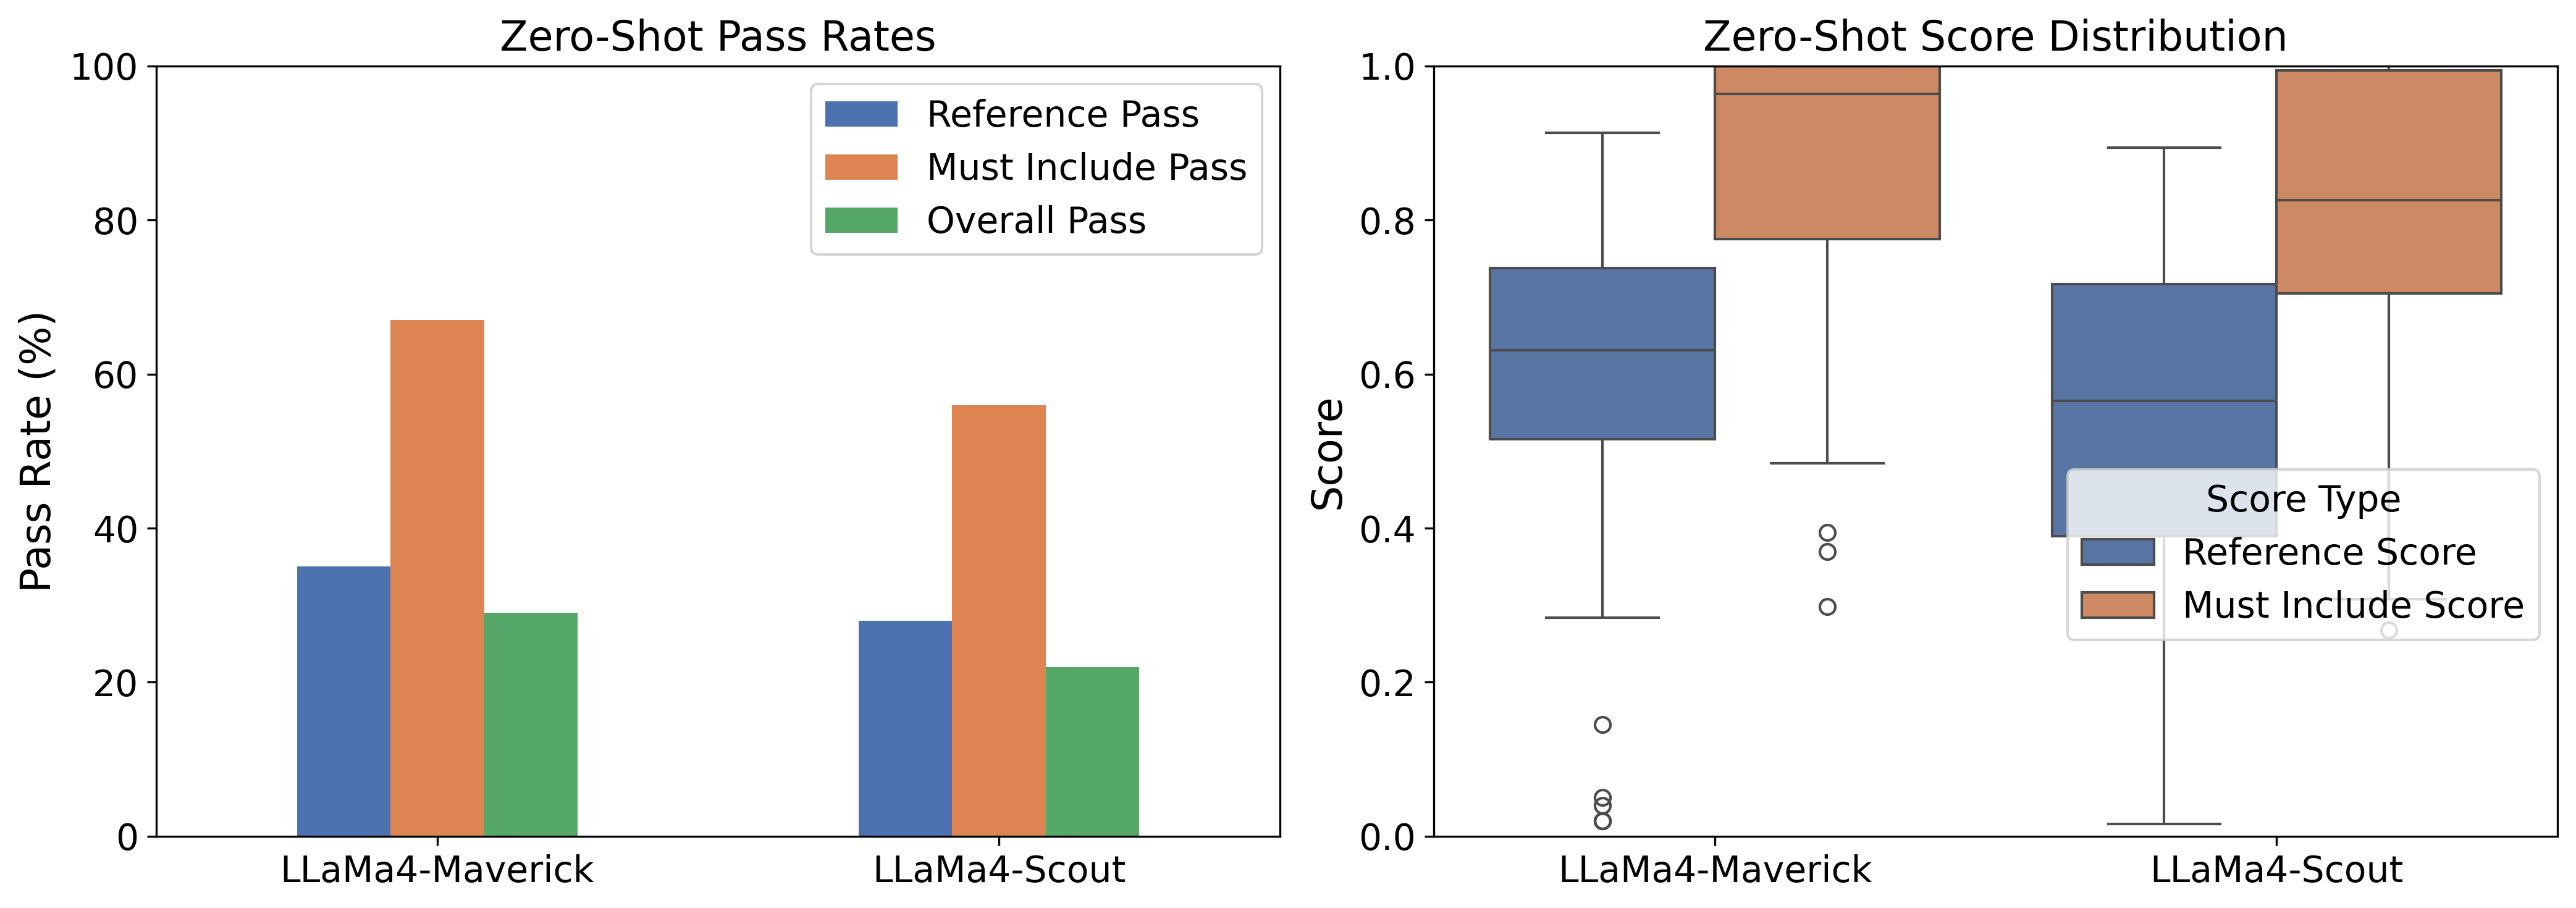

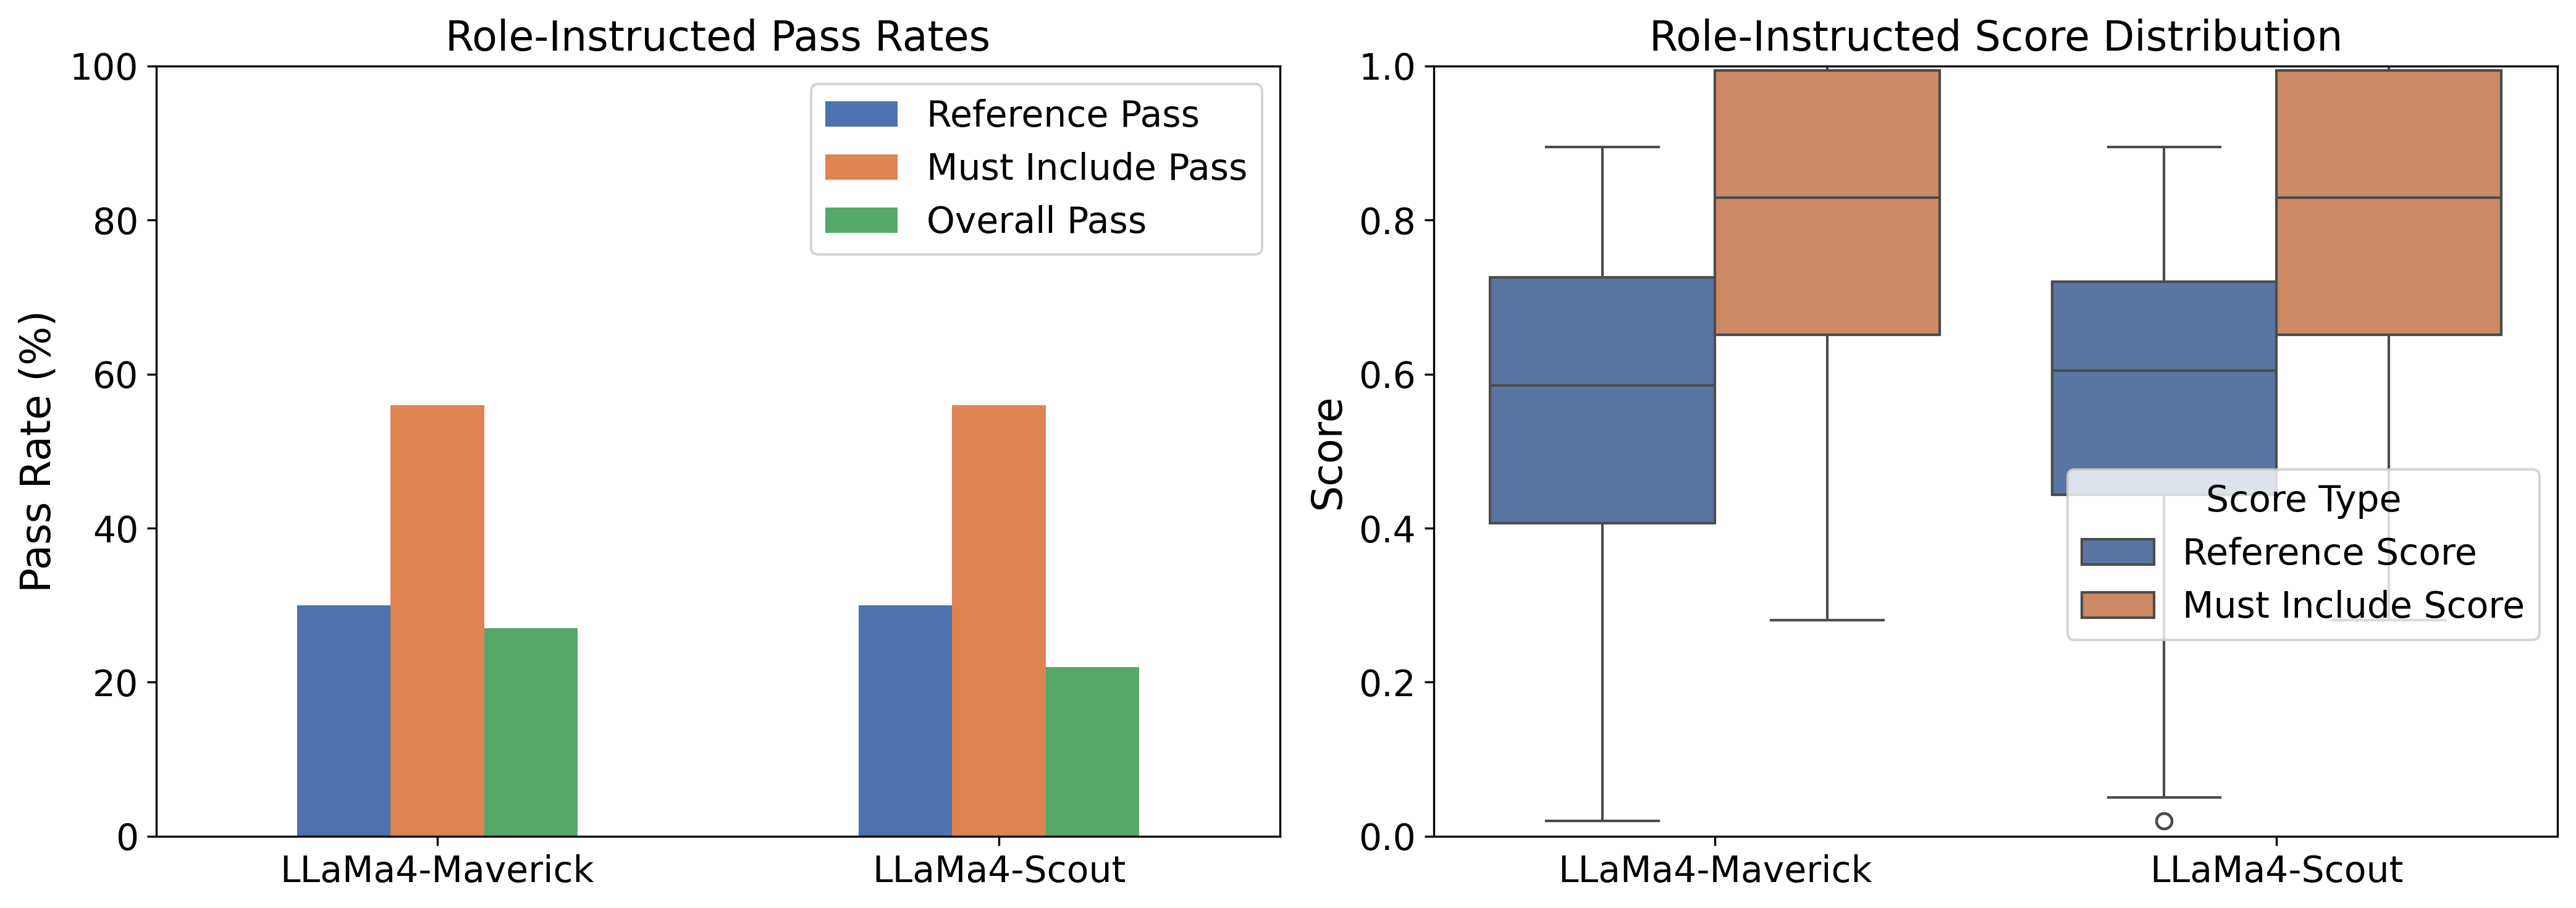

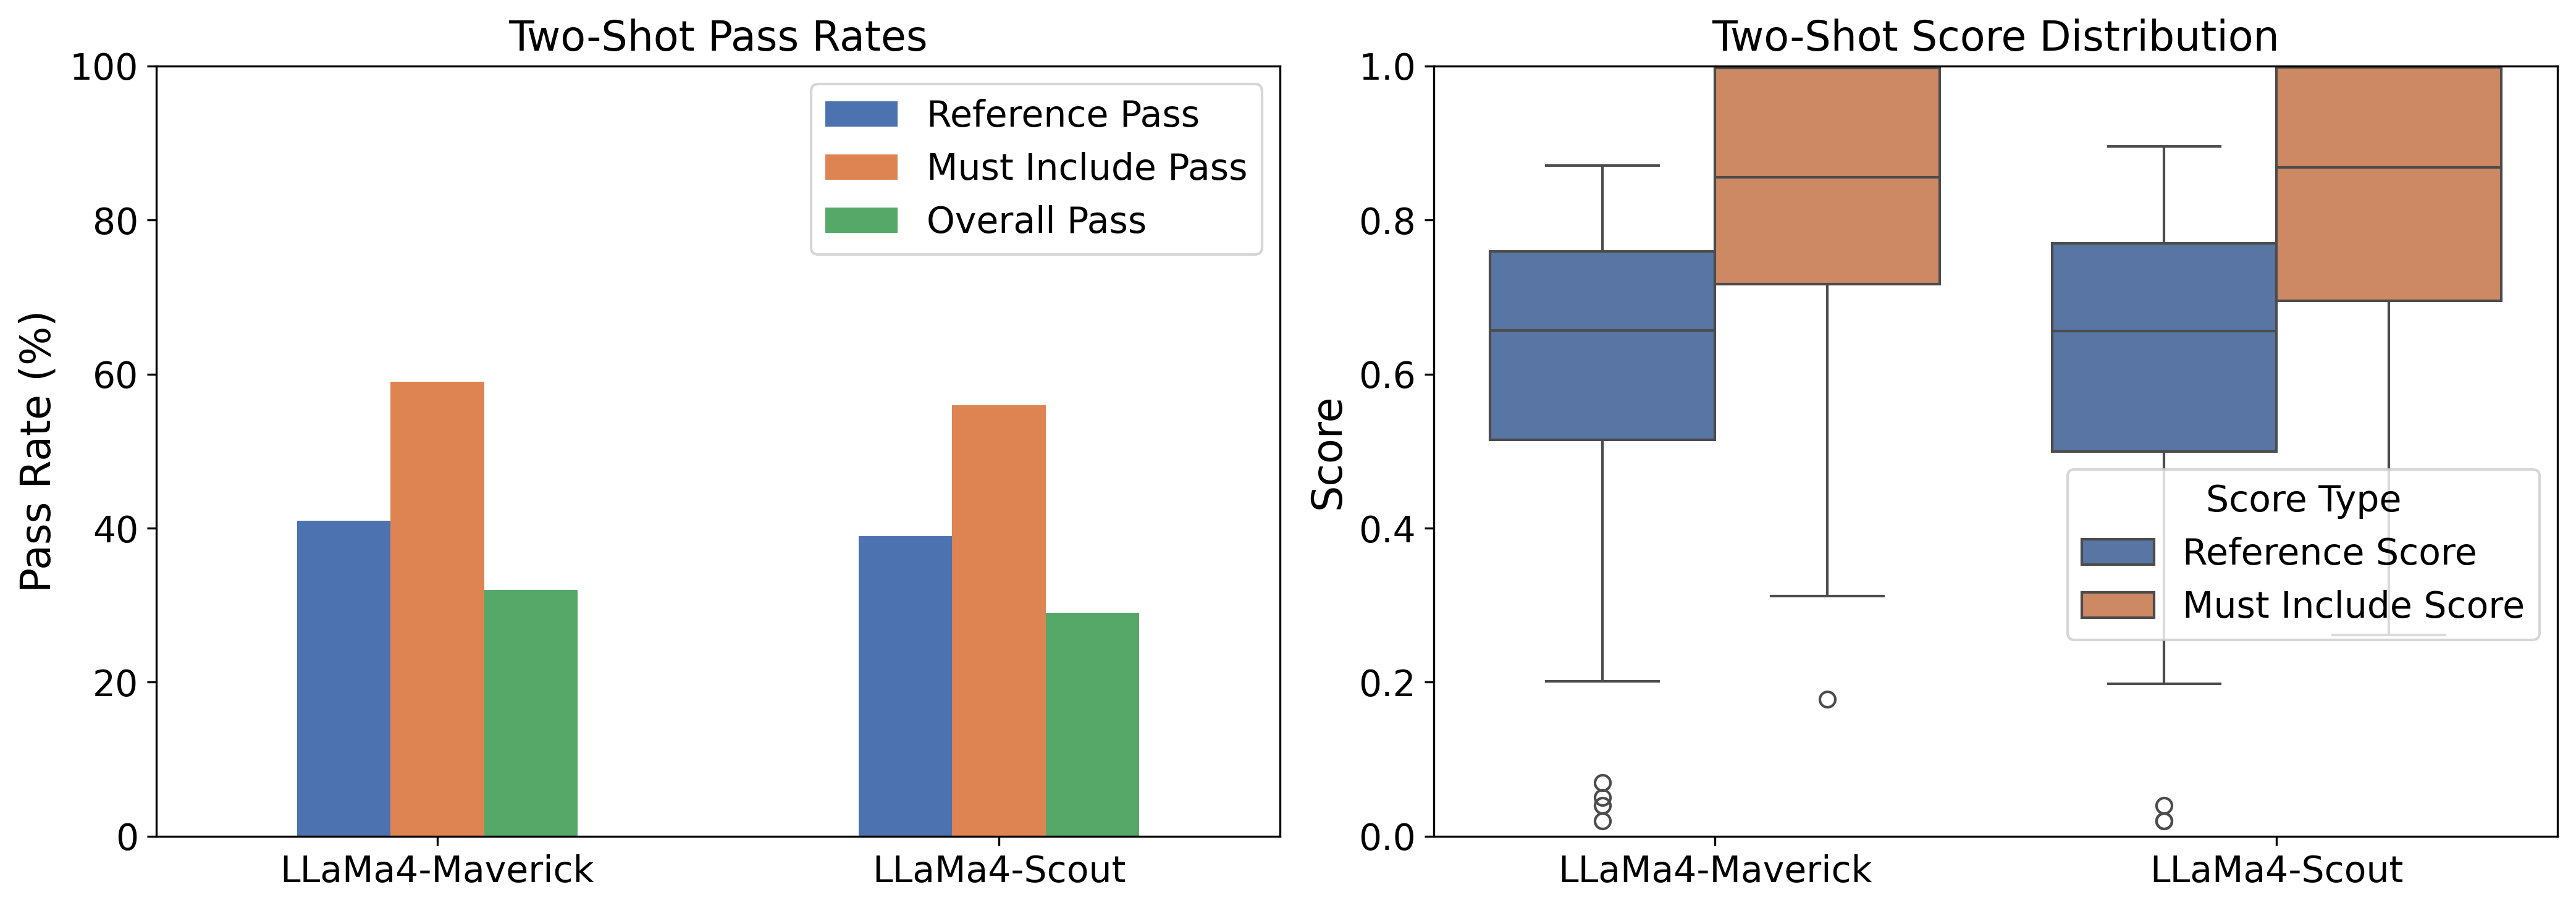


Zeroshot Pass Rates Significance:
Reference Pass: p = 0.3611
Must Include Pass: p = 0.1462
Overall Pass: p = 0.3304
Zeroshot Score Distribution Significance:
Reference Score: p = 0.0362
Must Include Score: p = 0.0207

Roleinstructed Pass Rates Significance:
Reference Pass: p = 1.0000
Must Include Pass: p = 1.0000
Overall Pass: p = 0.5108
Roleinstructed Score Distribution Significance:
Reference Score: p = 0.7941
Must Include Score: p = 1.0000

Twoshot Pass Rates Significance:
Reference Pass: p = 0.8852
Must Include Pass: p = 0.7748
Overall Pass: p = 0.7587
Twoshot Score Distribution Significance:
Reference Score: p = 0.9492
Must Include Score: p = 0.6214


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from scipy.stats import ttest_ind, chi2_contingency
import numpy as np

# --------------------- CONFIGURATION ----------------------------------------
sns.set_palette("deep")
plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.bbox": "tight",
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "legend.title_fontsize": 14,
})

DATA_DIR = "../script/evaluations"
STRATEGIES = ["zeroshot", "roleinstructed", "twoshot"]

# --------------------- LOAD DATA -------------------------------------------
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {DATA_DIR}")

frames = []
for path in csv_files:
    df = pd.read_csv(path)
    name = os.path.splitext(os.path.basename(path))[0].lower()

    if "zeroshot" in name:
        df["strategy"] = "zeroshot"
    elif "roleinstructed" in name:
        df["strategy"] = "roleinstructed"
    elif "twoshot" in name:
        df["strategy"] = "twoshot"
    else:
        df["strategy"] = "unknown"

    df["display_model"] = (
        "LLaMa4-Maverick" if "maverick" in name else "LLaMa4-Scout"
    )
    frames.append(df)

df = pd.concat(frames, ignore_index=True)

# --------------------- PLOTTING -------------------------------------------
for strat in STRATEGIES:
    subset = df[df["strategy"] == strat]
    if subset.empty:
        continue

    title_part = {
        "zeroshot": "Zero-Shot",
        "roleinstructed": "Role-Instructed",
        "twoshot": "Two-Shot",
    }[strat]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Pass Rate Bar Plot ----------------------------------------------------
    pr = (
        subset.groupby("display_model")[
            ["reference_pass", "must_include_pass", "overall_pass"]
        ].mean()
        * 100
    )
    pr.plot(kind="bar", ax=axes[0], rot=0)
    axes[0].set_title(f"{title_part} Pass Rates")
    axes[0].set_ylabel("Pass Rate (%)", fontsize=16)
    axes[0].set_xlabel("", fontsize=16)
    axes[0].set_ylim(0, 100)
    axes[0].tick_params(axis='x', labelsize=14)
    axes[0].tick_params(axis='y', labelsize=14)
    axes[0].legend([
        "Reference Pass",
        "Must Include Pass",
        "Overall Pass",
    ], fontsize=14)

    # Score Distribution Box Plot -----------------------------------------
    melt = pd.melt(
        subset,
        id_vars=["display_model"],
        value_vars=["reference_score", "must_include_score"],
        var_name="score_type",
        value_name="score",
    )
    melt["score_type"] = melt["score_type"].map(
        {
            "reference_score": "Reference Score",
            "must_include_score": "Must Include Score",
        }
    )

    sns.boxplot(
        x="display_model",
        y="score",
        hue="score_type",
        data=melt,
        ax=axes[1],
    )
    axes[1].set_title(f"{title_part} Score Distribution")
    axes[1].set_ylabel("Score", fontsize=16)
    axes[1].set_xlabel("", fontsize=16)
    axes[1].set_ylim(0, 1)
    axes[1].tick_params(axis='x', labelsize=14)
    axes[1].tick_params(axis='y', labelsize=14)
    axes[1].legend(
        title="Score Type",
        fontsize=14,
        title_fontsize=14,
        loc="upper right",
        bbox_to_anchor=(1.0, 0.50),  # slightly above and right
    )

    plt.tight_layout()
    plt.show()

# --------------------- STATISTICAL SIGNIFICANCE ---------------------------
for strat in STRATEGIES:
    sd = df[df["strategy"] == strat].copy()
    if sd.empty:
        continue

    sd["reference_pass_num"] = sd["reference_pass"].astype(int)
    sd["must_include_pass_num"] = sd["must_include_pass"].astype(int)
    sd["overall_pass_num"] = sd["overall_pass"].astype(int)

    def chi_p(cont):
        return chi2_contingency(cont)[1] if cont.shape == (2, 2) else np.nan

    p_ref = chi_p(pd.crosstab(sd["display_model"], sd["reference_pass"]))
    p_inc = chi_p(pd.crosstab(sd["display_model"], sd["must_include_pass"]))
    p_ovr = chi_p(pd.crosstab(sd["display_model"], sd["overall_pass"]))

    print(f"\n{strat.capitalize()} Pass Rates Significance:")
    print("Reference Pass: p = {:.4f}".format(p_ref) if not np.isnan(p_ref) else "Reference Pass: Insufficient data")
    print("Must Include Pass: p = {:.4f}".format(p_inc) if not np.isnan(p_inc) else "Must Include Pass: Insufficient data")
    print("Overall Pass: p = {:.4f}".format(p_ovr) if not np.isnan(p_ovr) else "Overall Pass: Insufficient data")

    m_ref = sd[sd["display_model"] == "LLaMa4-Maverick"]["reference_score"]
    s_ref = sd[sd["display_model"] == "LLaMa4-Scout"]["reference_score"]
    m_inc = sd[sd["display_model"] == "LLaMa4-Maverick"]["must_include_score"]
    s_inc = sd[sd["display_model"] == "LLaMa4-Scout"]["must_include_score"]

    t_ref = ttest_ind(m_ref, s_ref, nan_policy="omit").pvalue
    t_inc = ttest_ind(m_inc, s_inc, nan_policy="omit").pvalue

    print(f"{strat.capitalize()} Score Distribution Significance:")
    print("Reference Score: p = {:.4f}".format(t_ref))
    print("Must Include Score: p = {:.4f}".format(t_inc))

# Step 4 – Helper Functions (OLD)

In [34]:
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams

reference_coverage_eval = GEval(
    name="Referentie-dekking (SEE-Benchmark)",
    criteria=(
        "Beoordeel hoe goed de modeloutput overeenkomt met de essentie van de referentiebeschrijving. "
        "Vergelijk het met het nakijken van een open vraag: parafraseren en andere woordvolgorde mogen, zolang de kern van het antwoord gelijk blijft. "
        "Hoe meer belangrijke en relevante elementen correct aanwezig zijn, hoe hoger de score. "
        "De beschrijving moet functioneel bruikbaar zijn voor een blinde gebruiker en volledig in het Nederlands zijn."
    ),
    evaluation_params=[
        LLMTestCaseParams.ACTUAL_OUTPUT,
        LLMTestCaseParams.EXPECTED_OUTPUT
    ],
    evaluation_steps=[
        "De beschrijving moet volledig in het Nederlands zijn. Engelse termen zijn alleen toegestaan als ze letterlijk ook in de referentie staan. Als er Engelse termen voorkomen die niet in de referentie staan, geef een lage score (onder 0.3).",
        "Controleer of alle belangrijke en functioneel relevante elementen uit de referentie aanwezig zijn in de modeloutput, ook als ze net anders genoemd worden, zolang de essentie van het functioneel relevante element maar overkomt. Als er iets ontbreekt, trek dan punten af.",
        "Parafrasering is toegestaan, zolang betekenis en inhoud behouden blijven. Als de betekenis verandert of vager wordt, trek dan punten af.",
        "Als er elementen genoemd worden die niet in de referentie staan (zoals extra knoppen of functionaliteiten), trek dan punten af.",
        "Als de modeloutput visuele of stilistische details bevat die niet in de referentie staan én geen functioneel doel dienen, trek dan punten af.",
        "Als de modeloutput veel langer is dan nodig of onnodige omschrijvingen bevat, trek dan punten af."
    ],
    model="gpt-4o",
    threshold=0.7
)


In [ ]:
from deepeval import evaluate
from deepeval.test_case import LLMTestCase
import pandas as pd

model_outputs_df = pd.read_excel("../script/results/meta-llama/Llama-4-Scout-17B-16E-Instruct_zero-shot_20250628_0344.xlsx")

test_cases = []
for idx, row in model_outputs_df.iterrows():
    image_id = str(row['image_id']).zfill(3)
    model_output = row['model_output']

    reference = None
    for annotation in annotations:
        ann_id = str(annotation.get('image_id', '')).strip()
        if ann_id == image_id:
            reference = annotation.get('reference_description', None)
            break

    if reference is None:
        print(f"Warning: No reference found for image_id {image_id}")
        continue

    test_cases.append(
        LLMTestCase(
            input="",
            actual_output=model_output,
            expected_output=reference,
            additional_metadata={"image_id": image_id}  # Add this line
        )
    )

evaluation_results = evaluate(test_cases=test_cases, metrics=[reference_coverage_eval])

✨ You're running DeepEval's latest Referentie-dekking (SEE-Benchmark) (GEval) Metric! (using gpt-4o, strict=False,
async_mode=True)...

Evaluating 100 test case(s) in parallel: |          |  0% (0/100) [Time Taken: 00:00, ?test case/s]

KeyboardInterrupt: 

: 

In [ ]:
# Extract individual test scores from the evaluation results
individual_scores = []
for i, test_result in enumerate(evaluation_results.test_results):
    metric_data = test_result.metrics_data[0]  # First (and likely only) metric
    
    individual_scores.append({
    'test_case_index': i,
    'image_id': test_result.additional_metadata.get('image_id', 'unknown'),  # Get from metadata
    'score': metric_data.score,
    'pass': metric_data.success,
    'reason': metric_data.reason,
    'error': metric_data.error
    })

# Create DataFrame with individual scores
scores_df = pd.DataFrame(individual_scores)

# Calculate overall pass rate from individual results
total_tests = len(scores_df)
passed_tests = scores_df['pass'].sum()
overall_pass_rate = (passed_tests / total_tests) * 100

print("="*60)
print("INDIVIDUAL TEST SCORES")
print("="*60)
print(scores_df[['image_id', 'score', 'pass']].to_string(index=False))

print(f"\n{'='*60}")
print("OVERALL SUMMARY")
print("="*60)
print(f"Overall Pass Rate: {overall_pass_rate:.2f}%")
print(f"Passed Tests: {scores_df['pass'].sum()}/{len(scores_df)}")
print(f"Average Score: {scores_df['score'].mean():.4f}")

# Optionally save to CSV
scores_df.to_csv('test_scores.csv', index=False)
print(f"\nDetailed results saved to test_scores.csv")

INDIVIDUAL TEST SCORES
image_id    score  pass
     003 0.050000 False
     007 0.660500 False
     018 0.850000  True
     012 0.050000 False
     015 0.070000 False
     020 0.020000 False
     001 0.670925 False
     011 0.677276 False
     006 0.070000 False
     009 0.703138  True
     010 0.060000 False
     004 0.040000 False
     016 0.950000  True
     019 0.050000 False
     017 0.060000 False
     008 0.040000 False
     013 0.040000 False
     014 0.070000 False
     002 0.323108 False
     032 0.020000 False
     005 0.761843  True
     036 0.020000 False
     033 0.040000 False
     021 0.696548 False
     039 0.423886 False
     035 0.441242 False
     026 0.464813 False
     046 0.850000  True
     025 0.395009 False
     047 0.050000 False
     022 0.070000 False
     043 0.465492 False
     031 0.080000 False
     023 0.587737 False
     049 0.020000 False
     048 0.050000 False
     024 0.020000 False
     042 0.050000 False
     057 0.040000 False
     044 0.633819

In [ ]:
from deepeval import evaluate
from deepeval.test_case import LLMTestCase

# Shared reference
reference = "Op de pagina staat bovenaan een donkerblauwe balk met het logo van Microsoft Teams en een knop ‘Sign out’. In het midden staat de titel “Join a meeting”. Daaronder zijn twee velden: ‘Meeting ID’ en ‘Passcode’. Onderaan staat een knop ‘Join now’ en daarnaast een link ‘Learn more’."

# Model outputs for 6 test cases
model_outputs = [
    "De webpagina toont bovenaan een donkerblauwe balk met het Microsoft Teams-logo en een knop ‘Sign out’. In het midden staat de tekst “Join a meeting” met daaronder twee velden: ‘Meeting ID’ en ‘Passcode’. Onderaan staan de knoppen ‘Join now’ en ‘Learn more’.",
    "De pagina toont een donkerblauwe balk met het Teams-logo en de knop ‘Sign out’. Daaronder een witte sectie met “Join a meeting” in vetgedrukte letters, gevolgd door twee velden (‘Meeting ID’, ‘Passcode’). De knop ‘Join now’ is blauw en heeft afgeronde hoeken. Naast de knop staat een kleine link ‘Learn more’.",
    "Bovenaan staat het Teams-logo en ‘Sign out’. Middenin staat “Join a meeting” met drie velden: ‘Meeting ID’, ‘Passcode’, en ‘Naam’. Onderaan: ‘Join now’ en ‘Learn more’.",
    "De pagina toont bovenaan een blauwe balk met het logo en een knop ‘Afmelden’. In het midden staat ‘Join a meeting’ en velden ‘Meeting ID’, ‘Passcode’. Onderaan de pagina: knoppen ‘Join now’ en ‘Meer info’.",
    "Op de pagina staat een blauwe balk met logo en ‘Sign out’. Centraal staat “Join a meeting” in grote letters, gevolgd door velden ‘Meeting ID’, ‘Passcode’. Onderaan ‘Join now’ (blauwe knop) en ‘Learn more’. Layout is responsief en modern.",
    "Bovenaan de pagina staat een donkerblauwe balk met links het Microsoft Teams-logo en rechts de knop ‘Sign out’. In het midden van het scherm staat in grote letters “Join a meeting”, gevolgd door twee invoervelden met de labels ‘Meeting ID’ en ‘Passcode’. Helemaal onderaan bevindt zich een blauwe knop ‘Join now’ met daarnaast de link ‘Learn more’. De termen zijn in het Engels omdat ze exact zo op het scherm staan. De layout is overzichtelijk en functioneel."
    # Case 7 – Fully English output, should score very low
    "At the top of the screen is a dark blue bar with the Microsoft Teams logo on the left and a ‘Sign out’ button on the right. In the center is the title “Join a meeting”, followed by fields labeled ‘Meeting ID’ and ‘Passcode’. At the bottom, there is a blue ‘Join now’ button and a link labeled ‘Learn more’."

]

# Build and evaluate
test_cases = [
    LLMTestCase(input="", actual_output=output, expected_output=reference)
    for output in model_outputs
]
evaluate(test_cases=test_cases, metrics=[reference_coverage_eval])


✨ You're running DeepEval's latest Referentie-dekking (SEE-Benchmark) (GEval) Metric! (using gpt-4o, strict=False,
async_mode=True)...

Evaluating 6 test case(s) in parallel: |█▋        | 17% (1/6) [Time Taken: 00:03,  3.99s/test case]

False !!!!!!!!!!!!


Evaluating 6 test case(s) in parallel: |███▎      | 33% (2/6) [Time Taken: 00:04,  1.81s/test case]

False !!!!!!!!!!!!


Evaluating 6 test case(s) in parallel: |█████     | 50% (3/6) [Time Taken: 00:05,  1.34s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 6 test case(s) in parallel: |██████████|100% (6/6) [Time Taken: 00:05,  1.07test case/s]

False !!!!!!!!!!!!


Metrics Summary

  - ❌ Referentie-dekking (SEE-Benchmark) (GEval) (score: 0.05, threshold: 0.8, strict: False, evaluation model: gpt-4o, reason: The description includes English terms not in the reference, and it repeats content in English. The layout details are more extensive than necessary., error: None)

For test case:

  - input: 
  - actual output: Bovenaan de pagina staat een donkerblauwe balk met links het Microsoft Teams-logo en rechts de knop ‘Sign out’. In het midden van het scherm staat in grote letters “Join a meeting”, gevolgd door twee invoervelden met de labels ‘Meeting ID’ en ‘Passcode’. Helemaal onderaan bevindt zich een blauwe knop ‘Join now’ met daarnaast de link ‘Learn more’. De termen zijn in het Engels omdat ze exact zo op het scherm staan. De layout is overzichtelijk en functioneel.At the top of the screen is a dark blue bar with the Microsoft Teams logo on the left and a ‘Sign out’ button on the right. In the center is the title “Join a mee

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

EvaluationResult(test_results=[TestResult(name='test_case_5', success=False, metrics_data=[MetricData(name='Referentie-dekking (SEE-Benchmark) (GEval)', threshold=0.8, success=False, score=0.05, reason='The description includes English terms not in the reference, and it repeats content in English. The layout details are more extensive than necessary.', strict_mode=False, evaluation_model='gpt-4o', error=None, evaluation_cost=0.0020800000000000003, verbose_logs='Criteria:\nBeoordeel hoe goed de modeloutput overeenkomt met de essentie van de referentiebeschrijving. Vergelijk het met het nakijken van een open vraag: parafraseren en andere woordvolgorde mogen, zolang de kern van het antwoord gelijk blijft. Hoe meer belangrijke en relevante elementen correct aanwezig zijn, hoe hoger de score. De beschrijving moet functioneel bruikbaar zijn voor een blinde gebruiker en volledig in het Nederlands zijn. \n \nEvaluation Steps:\n[\n    "De beschrijving moet volledig in het Nederlands zijn. Engel

# Additional (testing)

In [ ]:
must_include_coverage_eval = GEval(
    name="Verplichte Elementen Dekking",
    criteria="Alle verplichte elementen uit de lijst moeten herkenbaar en in het Nederlands aanwezig zijn in de modeloutput, ook als synoniem of parafrase. Het belangrijkste is dat de essentie van het element behouden blijft.",
    evaluation_params=[
        LLMTestCaseParams.ACTUAL_OUTPUT,
        LLMTestCaseParams.INPUT
    ],
    evaluation_steps=[
        "Controleer voor elk verplicht element of het in de output staat, ook synoniemen of parafraseringen tellen even zwaar mee."
        "Als alles aanwezig is telt dit sterk mee."
    ],
    model="gpt-4o",
    threshold=0.8
)


In [ ]:
import json
from deepeval import evaluate
from deepeval.test_case import LLMTestCase

must_include = ["zoekbalk", "knop ‘Inloggen’", "menu"]

model_outputs = [
    "Bovenaan de pagina staat een zoekbalk, rechts daarvan de knop ‘Inloggen’, en onderaan een menu met verschillende opties.",
    "Helemaal bovenin is een veld om te zoeken, daarnaast vind je de login-knop. Onderaan staan de menu-opties.",
    "Bovenaan staat een zoekbalk en een knop ‘Inloggen’.",
    "At the top is a search bar, next to it is the login button.",
    "De pagina bevat een zoekbalk, een knop ‘Inloggen’, een afbeelding en een helpknop.",
    "Er is een inlogknop rechtsboven."
]

must_include_lists = [must_include for _ in model_outputs]

test_cases = [
    LLMTestCase(
        input=json.dumps({"must_include": mi}),
        actual_output=output,
        expected_output=""
    )
    for mi, output in zip(must_include_lists, model_outputs)
]

results = evaluate(test_cases=test_cases, metrics=[must_include_coverage_eval])


✨ You're running DeepEval's latest Verplichte Elementen Dekking (GEval) Metric! (using gpt-4o, strict=False, 
async_mode=True)...

Evaluating 6 test case(s) in parallel: |█▋        | 17% (1/6) [Time Taken: 00:02,  2.47s/test case]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 6 test case(s) in parallel: |█████     | 50% (3/6) [Time Taken: 00:02,  1.35test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Evaluating 6 test case(s) in parallel: |██████████|100% (6/6) [Time Taken: 00:03,  1.91test case/s]

False !!!!!!!!!!!!
False !!!!!!!!!!!!


Metrics Summary

  - ❌ Verplichte Elementen Dekking (GEval) (score: 0.6293615926850925, threshold: 0.8, strict: False, evaluation model: gpt-4o, reason: The output includes 'zoekbalk' and 'knop ‘Inloggen’', but is missing 'menu'., error: None)

For test case:

  - input: {"must_include": ["zoekbalk", "knop \u2018Inloggen\u2019", "menu"]}
  - actual output: De pagina bevat een zoekbalk, een knop ‘Inloggen’, een afbeelding en een helpknop.
  - expected output: 
  - context: None
  - retrieval context: None


Metrics Summary

  - ❌ Verplichte Elementen Dekking (GEval) (score: 0.4865014359969636, threshold: 0.8, strict: False, evaluation model: gpt-4o, reason: The output includes 'zoekbalk' as 'search bar' and 'knop ‘Inloggen’' as 'login button', but 'menu' is missing., error: None)

For test case:

  - input: {"must_include": ["zoekbalk", "knop \u2018Inloggen\u2019", "menu"]}
  - actual output: At the top is a search bar, next to it is the login but

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.